In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.ToTensor()

traindata = torchvision.datasets.MNIST('./NewData/', download=True, transform=transform, train = True)

In [5]:
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=64, num_workers=4)

In [6]:
dataIter = iter(trainloader)
imgs, labels = dataIter.next()
Z_dim = 10     # dimension of the input noise for generator
H_dim = 128    # number of hidden neurons in our hidden layer
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1) #image size
Y_dim = labels.view(labels.size(0), -1).size(1)
print(X_dim, Y_dim)

784 1


In [7]:
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [8]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
#         self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)

In [9]:
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
        )
#         self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)

In [10]:
G = Gen().to(device)
D = Dis().to(device)

In [11]:
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

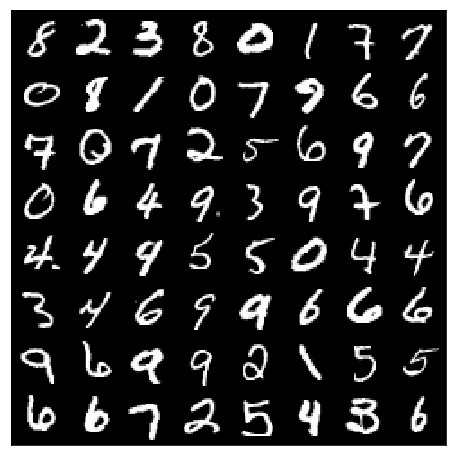

In [12]:
# Visualize a grid of imgs
def imshow(imgs):
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    # transfoming tensors back to numpy 
    npimgs = imgs.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)

In [13]:
def energy(X):
    reconstructed_X = D(X)
    return torch.mean(torch.sum((X - reconstructed_X)**2, 1))

Epoch:0,   G_loss:9.088915846495231,   D_loss:15.502564721524335


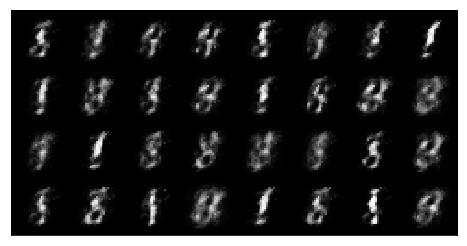

Epoch:5,   G_loss:5.347695903737407,   D_loss:7.829253671011691


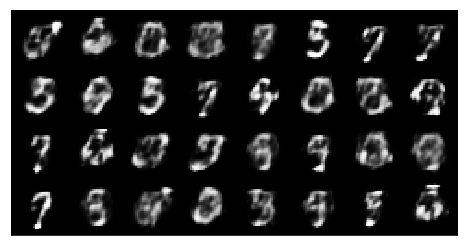

Epoch:10,   G_loss:5.15422148872286,   D_loss:7.825235995656646


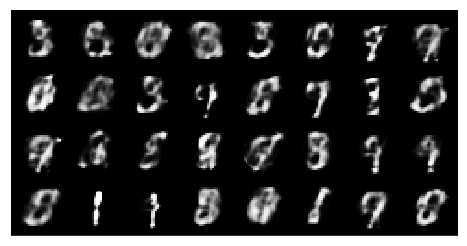

Epoch:15,   G_loss:5.169516080986462,   D_loss:7.66846753640978


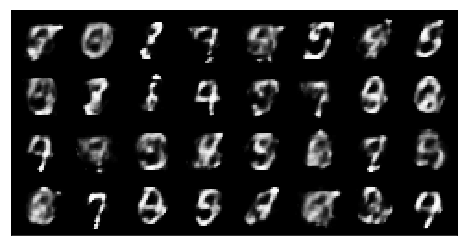

Epoch:20,   G_loss:5.153675699284844,   D_loss:7.653260010900274


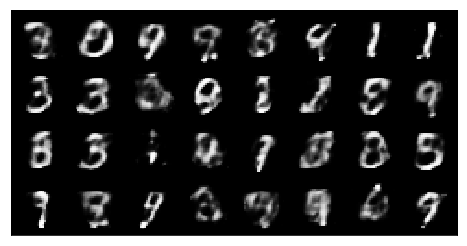

Epoch:25,   G_loss:5.1219068358956115,   D_loss:7.6788739924237674


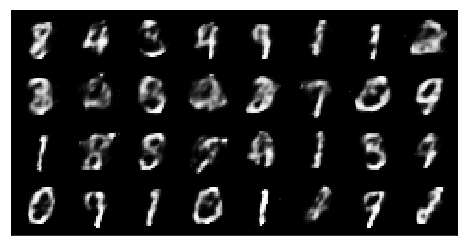

Epoch:30,   G_loss:5.09590078823602,   D_loss:7.696666507578608


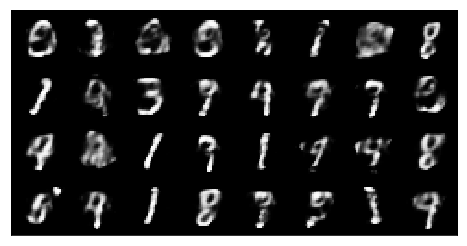

Epoch:35,   G_loss:5.1164838027344075,   D_loss:7.61633195958412


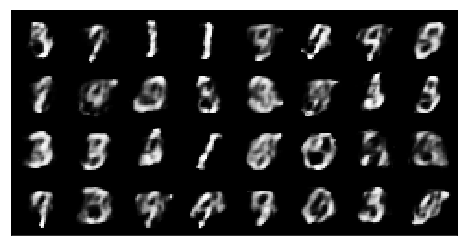

Epoch:40,   G_loss:5.1071278372807285,   D_loss:7.704486331451676


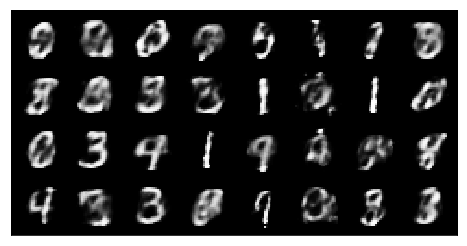

Epoch:45,   G_loss:5.096302568277062,   D_loss:7.71698107394074


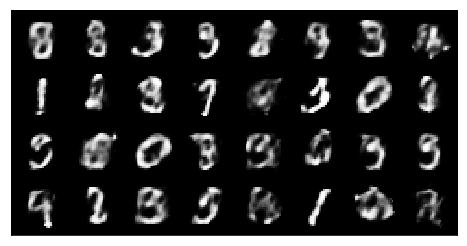

In [14]:
m = 5

for epoch in range(50):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i,data in enumerate(trainloader):
        X, _ = data
        mb_size = X.size(0)
        X = Variable(X.view(X.size(0), -1).to(device))
        
        
        # Random normal distribution for each image
        z = Variable(torch.randn(mb_size, Z_dim).to(device))
        
        # Defining the loss for Discriminator
        D_real_loss = energy(X)
        D_fake_loss = energy(G(z))
        D_loss = D_real_loss + F.relu(m - D_fake_loss)
        
        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = Variable(torch.randn(mb_size, Z_dim).to(device))
        G_loss = energy(G(z))
                
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
#         print('D_real_loss', D_real_loss.item(), 'D_fake_loss', D_fake_loss.item(), 'G_loss', G_loss.item())
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
    
    if epoch%5 == 0:
        print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
        samples = G(z).detach()
        samples = samples.view(samples.size(0), 1, 28, 28)
        imshow(samples)